2025-05-14 18:07:39.914652: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747246060.205553     101 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747246060.284686     101 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.6' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
2025-05-14 18:09:53.779477: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit

337/338 ━━━━━━━━━━━━━━━━━━━━ 2s 3s/step

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


338/338 ━━━━━━━━━━━━━━━━━━━━ 869s 3s/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 85s 3s/step

 Classification Report:
              precision    recall  f1-score   support

           1       0.94      0.81      0.87       270
           2       0.78      0.70      0.74       253
           3       0.66      0.71      0.69       236
           4       0.65      0.62      0.63       197
           5       0.61      0.91      0.73       112

    accuracy                           0.74      1068
   macro avg       0.73      0.75      0.73      1068
weighted avg       0.75      0.74      0.74      1068



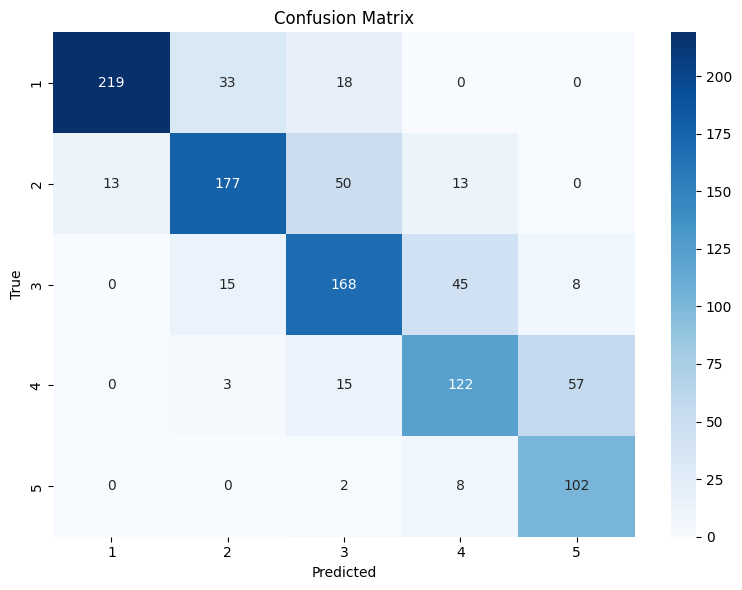

In [1]:
#--- Imports ---
import os, cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input, GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.optimizers import Adam
import albumentations as A

# --- Config ---
IMG_SIZE = 128
RESNET_SIZE = 224
train_img_dir = '/kaggle/input/pcb-defect-dataset/pcb-defect-dataset/train/images'
val_img_dir = '/kaggle/input/pcb-defect-dataset/pcb-defect-dataset/val/images'
test_img_dir = '/kaggle/input/pcb-defect-dataset/pcb-defect-dataset/test/images'

# --- Augmentations ---
augment = A.Compose([
    A.HorizontalFlip(p=0.5), A.RandomBrightnessContrast(p=0.5),
    A.Rotate(limit=20, p=0.5), A.RandomGamma(p=0.3),
    A.MotionBlur(p=0.3), A.CLAHE(p=0.2),
    A.GaussNoise(p=0.3), A.HueSaturationValue(p=0.3),
    A.GridDistortion(p=0.2)])

# --- Data Loader ---
def load_images(folder, size):
    paths = glob(os.path.join(folder, '*.jpg'))
    images, labels = [], []
    for path in paths:
        img = cv2.imread(path)
        img = cv2.resize(img, (size, size))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) / 255.0
        label = path.split('_')[-2]
        images.append(img)
        labels.append(label)
    return np.array(images), np.array(labels)

X_train, y_train = load_images(train_img_dir, IMG_SIZE)
X_test, y_test = load_images(test_img_dir, IMG_SIZE)

# --- Encode Labels ---
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

# --- Balance Classes ---
def balance_data(X, y):
    count = Counter(y)
    max_count = max(count.values())
    X_aug, y_aug = list(X), list(y)
    for label in count:
        imgs = [x for x, l in zip(X, y) if l == label]
        for _ in range(max_count - count[label]):
            img = imgs[np.random.randint(len(imgs))]
            aug_img = augment(image=(img * 255).astype('uint8'))['image'] / 255.0
            X_aug.append(aug_img)
            y_aug.append(label)
    return np.array(X_aug), np.array(y_aug)

X_train_bal, y_train_bal = balance_data(X_train, y_train)
y_train_bal_enc = le.transform(y_train_bal)

# --- Feature Extractor: CNN ---
# --- ResNet Feature Extractor ---
resnet_base = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=(RESNET_SIZE, RESNET_SIZE, 3)))
model_resnet = Model(inputs=resnet_base.input,
                     outputs=GlobalAveragePooling2D()(resnet_base.output))

def extract_resnet_features(X):
    X_resized = np.array([cv2.resize((img * 255).astype('uint8'), (RESNET_SIZE, RESNET_SIZE)) for img in X])
    X_pre = preprocess_input(X_resized.astype('float32'))
    return model_resnet.predict(X_pre, batch_size=32)

X_train_resnet_feat = extract_resnet_features(X_train_bal)
X_test_resnet_feat = extract_resnet_features(X_test)

# Train classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_resnet_feat, y_train_bal_enc)
y_pred = clf.predict(X_test_resnet_feat)


# --- Evaluation ---
print("\n Classification Report:")
print(classification_report(y_test_enc, y_pred, target_names=le.classes_))

cm = confusion_matrix(y_test_enc, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

In [2]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, average_precision_score
import time

# --- Evaluation ---
# --- Inference Time & FPS ---
start_time = time.time()
_ = clf.predict(X_test_resnet_feat)
end_time = time.time()

total_time = end_time - start_time
fps = len(X_test_resnet_feat) / total_time
print(f"\nTotal Inference Time: {total_time:.2f} seconds")
print(f" FPS (Frames per Second): {fps:.2f}")

# --- Per-Class Precision, Recall, F1 (Explicit) ---
precision = precision_score(y_test_enc, y_pred, average=None)
recall = recall_score(y_test_enc, y_pred, average=None)
f1 = f1_score(y_test_enc, y_pred, average=None)

print("\n Per-Class Metrics:")
for i, class_name in enumerate(le.classes_):
    print(f"{class_name}: Precision={precision[i]:.3f}, Recall={recall[i]:.3f}, F1={f1[i]:.3f}")

# --- mAP (mean Average Precision) ---
# Convert labels to one-hot
from sklearn.preprocessing import label_binarize
y_test_bin = label_binarize(y_test_enc, classes=range(len(le.classes_)))
y_proba = clf.predict_proba(X_test_resnet_feat)

map_score = average_precision_score(y_test_bin, y_proba, average='macro')
print(f"\nmAP (Mean Average Precision): {map_score:.4f}")

# --- Overall AUC Score (Multi-class ROC AUC) ---
auc_score = roc_auc_score(y_test_bin, y_proba, average='macro', multi_class='ovr')
print(f" Overall AUC Score: {auc_score:.4f}")



Total Inference Time: 0.06 seconds
 FPS (Frames per Second): 18134.59

 Per-Class Metrics:
1: Precision=0.944, Recall=0.811, F1=0.873
2: Precision=0.776, Recall=0.700, F1=0.736
3: Precision=0.664, Recall=0.712, F1=0.687
4: Precision=0.649, Recall=0.619, F1=0.634
5: Precision=0.611, Recall=0.911, F1=0.731

mAP (Mean Average Precision): 0.7748
 Overall AUC Score: 0.9423
